## DC Figs 6-18

In [1]:
import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys
from wfOpto import *

In [2]:
#work
plt.style.use(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\ALpres.mplstyle')

In [204]:
#personal
plt.style.use(r'C:\GitHub\steinmetzlab\ALpres.mplstyle')

### loading data

In [54]:
data830 = wfOpto((Path(r'Y:\Subjects\AL_0023\2023-08-30\1')), listExps=[np.r_[:1350], np.r_[1350:1800]])

In [29]:
data717 = wfOpto(Path(r'Y:\Subjects\ZYE_0069\2023-07-17\1'), [np.r_[:334], np.r_[334:667]])

In [89]:
np.unique((data717.galvoY[data717.listExps[0]]))

array([0.])

In [30]:
# process 717
pixel_ix = np.ravel_multi_index((246,198), (data717.py, data717.py)) # the pixel
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

trials = np.squeeze(np.argwhere(data717.laserPowers[data717.listExps[0]]==3.2)) # the trials
time = [np.linspace(-.3+i, i+1, n_samples) for i in data717.laserOn[data717.listExps[0][trials]]] 
trs = np.squeeze(np.array(time))

opto = []
for iT, tr in enumerate(time):
    wf = data717.tToWFManual(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = data717.svdSpat[pixel_ix] @ dwf
    opto.append(mov)
opto = np.array(opto)

In [32]:
len(trials)

54

In [55]:
# process 830
power = 3
pixel = (410, 428)
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((428, 410), (data830.py, data830.px))
pows = np.argwhere(data830.laserPowers[data830.listExps[0]] == power).ravel()
onTimes = data830.laserOn[data830.listExps[0]][pows]
trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

flicker = []
for iT, tr in enumerate(trs):
    wf = data830.tToWFManual(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = data830.svdSpat[pixel_ix] @ dwf
    flicker.append(mov)
flicker = np.array(flicker)

In [35]:
len(trs)

150

### panels

In [ ]:
def mouseImg(ax):
    im_f = r'C:\Users\nadia\Downloads\optowf.png'
    im = plt.imread(im_f)
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.text(.5,.05,'screen',transform=ax.transAxes,ha='center',va='bottom',fontsize='medium')
    plt.text(0, .67, 'laser', transform=ax.transAxes,ha='left',va='center',fontsize='medium', c='red')

In [ ]:
def taskImg(ax):
    im_f = r'C:\Users\nadia\Downloads\task.png'
    im = plt.imread(im_f)
    plt.imshow(im[0:650, 20:570])
    plt.xticks([])
    plt.yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

In [110]:
def panelOptoVisResp():
    f = plt.figure(figsize=(4/1.5, 3/1.5), dpi=300)
    ax = plt.gca()
    flicker_mean = np.mean(flicker, axis=0)
    opto_mean = np.mean(opto, axis=0)
    flicker_scale = flicker_mean*.45454545

    ax.plot(timestamps, opto_mean, color='blue')
    # ax.set_title("Optogenetic Stimulation and \nVisual Response Activity Traces")
    ax.set_ylabel('Brain activity')
    ax.plot(timestamps,flicker_scale,color='red')
    ax.axvspan(0,100,color='gray',alpha=.3,lw=0)
    # ax.legend(['opto resp','visual resp'])
    ax.set_xlim([-100,500])
    ax.set_ylim(ylim)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    plt.xlabel('Time from stim onset (s)')

In [206]:
def panelConfoundResp(ax, ylim):
    flicker_mean = np.mean(flicker, axis=0)
    opto_mean = np.mean(opto, axis=0)
    flicker_scale = flicker_mean*.45454545
    
    ax.plot(timestamps,flicker_scale+opto_mean,color='darkviolet')
    # ax.set_title("Resultant brain activity of \nOpto. and Visual Responses")
    ax.set_ylim(ylim)
    # plt.tick_params(axis='y', labelleft=False)
    plt.text(0.95, 0.95, 'Resultant brain activity of\nopto and visual responses', 
             transform=ax.transAxes, ha='right', va='top', fontsize='x-small')
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0)
    plt.xticks([0, 500, 1000], [0, 0.5, 1])
    plt.xlabel('Time from stim onset (s)')
    plt.ylabel('Brain activity')

In [173]:
def panelPowerWithFlicker():
    f = plt.figure(figsize=(4/1.5, 3/1.5), dpi=300)
    ax = plt.gca()
    pixel = (410, 428)
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000
    power=3
    
    pixel_ix = np.ravel_multi_index((428, 410), (data830.py, data830.px))
    pows = np.argwhere(data830.laserPowers[data830.listExps[1]] == power).ravel()
    onTimes = data830.laserOn[data830.listExps[1]][pows]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    noFlicker = []
    for iT, tr in enumerate(trs):
        wf = data830.tToWFManual(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = data830.svdSpat[pixel_ix] @ dwf
        noFlicker.append(mov)
    noFlicker = np.array(noFlicker)

    plt.plot(timestamps, np.mean(noFlicker, axis=0), color='k')
    plt.fill_between(timestamps, \
                     np.mean(noFlicker, axis=0)-scipy.stats.sem(noFlicker,axis=0),\
                     np.mean(noFlicker,axis=0)+scipy.stats.sem(noFlicker,axis=0), color='k', alpha=0.3, lw=0, label='_nolegend_')
    
    plt.plot(timestamps, np.mean(flicker,axis=0),color='k',linestyle='dotted')
    plt.fill_between(timestamps, \
                     np.mean(flicker, axis=0)-scipy.stats.sem(flicker,axis=0),\
                     np.mean(flicker,axis=0)+scipy.stats.sem(flicker,axis=0), color='k', lw=0, label='_nolegend_', alpha=0.3)
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    # plt.legend()
    plt.xlim([-100,500])
    plt.xlabel('Time from stim onset(s)')
    plt.ylabel('Activity in visual cortex')
    plt.title(f'{power} mW opto stim')

In [134]:
def panelAllPowersFlicker():
    f = plt.figure(figsize=(4/1.5, 3/1.5), dpi=300)
    ax = plt.gca()
    powers = np.unique(data830.laserPowers)
    pixel = (410, 428)
    pxPowersFlicker = [] 
    pxPowersNoFlicker = []
    n_samples = 650
    
    pixel_ix = np.ravel_multi_index((428, 410), (data830.py, data830.px))
    for iP, power in enumerate(powers):
        if power >= 0:
            theseTrsFlicker = np.argwhere(data830.laserPowers[data830.listExps[0]]== power).ravel()
            # theseTrsFlicker=theseTrsFlicker[::3]
            onTimesFlicker = data830.laserOn[data830.listExps[0]][theseTrsFlicker]
            trsFlicker = [np.linspace(on+0, .25+on, n_samples) for on in onTimesFlicker]
            trsFlicker = np.squeeze(np.array(trsFlicker))
            
            theseTrsNFlicker = np.argwhere(data830.laserPowers[data830.listExps[1]]== power).ravel()
            onTimesNFlicker = data830.laserOn[data830.listExps[1]][theseTrsNFlicker]
            trsNFlicker = [np.linspace(0+on, .25+on, n_samples) for on in onTimesNFlicker]
            trsNFlicker = np.squeeze(np.array(trsNFlicker))
            
            thisPowerNFlicker = []
            thisPowerFlicker = []
            for iT, tr in enumerate(trsFlicker):
                wf = data830.tToWFManual(tr)
                dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
                dwf = np.array(dwf)
                mov = data830.svdSpat[pixel_ix] @ dwf
                thisPowerFlicker.append(mov)
            thisPowerFlicker = np.array(thisPowerFlicker)
            pxPowersFlicker.append(thisPowerFlicker)
    
            for iT, tr in enumerate(trsNFlicker):
                wf = data830.tToWFManual(tr)
                dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
                dwf = np.array(dwf)
                mov = data830.svdSpat[pixel_ix] @ dwf
                thisPowerNFlicker.append(mov)
            thisPowerNFlicker = np.array(thisPowerNFlicker)
            pxPowersNoFlicker.append(thisPowerNFlicker)   
    
    flickInt = []
    time=np.linspace(0,0.25,650)
    for count,pxPowers in enumerate(pxPowersFlicker):
        pxPowers = np.mean(pxPowers, axis=0)
        min = np.min(pxPowers)
        pxPowers = pxPowers+ (min*-1)
        int = np.trapz(y=pxPowers)
        flickInt.append(int)
    flickInt = np.array(flickInt)
    
    noflickInt = []
    time=np.linspace(0,0.25,650)
    for count,pxPowers in enumerate(pxPowersNoFlicker):
        pxPowers = np.mean(pxPowers, axis=0)
        min = np.min(pxPowers)
        pxPowers = pxPowers+ (min*-1)
        int = np.trapz(y=pxPowers)
        noflickInt.append(int)
    noflickInt = np.array(noflickInt)
    # plt.plot(np.unique(data830.laserPowers),noflickInt,c='red')

    dotkwargs = {'marker': '.', 'yerr': 0}
    constant = 100
    plt.errorbar(np.unique(data830.laserPowers), noflickInt/constant, c='forestgreen', label='without white noise', **dotkwargs)
    
    # plt.plot(np.unique(data830.laserPowers),flickInt,c='blue')
    plt.errorbar(np.unique(data830.laserPowers), flickInt/constant, c='darkorange', label='with white noise', **dotkwargs)
    
    plt.legend()
    plt.xlabel('Optogenetic laser power (mW)')
    plt.ylabel('Activity in visual cortex')
    # plt.title('Magnitude of Visual Response')

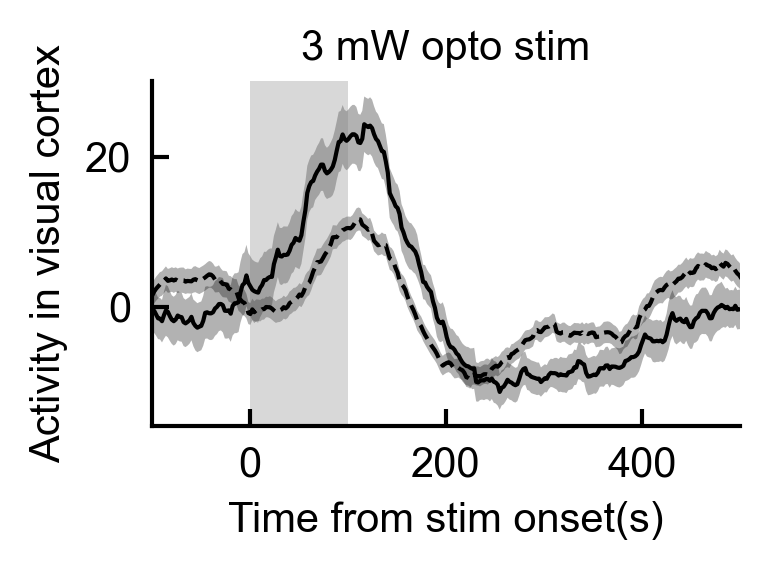

In [172]:
# f = plt.figure(figsize=(16, 8))
# gs = mpl.gridspec.GridSpec(2, 3)

# ax = plt.subplot(gs[0])
# mouseImg(ax)

# ax = plt.subplot(gs[1])
# ylim = (-10, 10)
# panelOptoVisResp(ax, ylim)

# ax = plt.subplot(gs[2])
# panelConfoundResp(ax, ylim)

# ax = plt.subplot(gs[3])
panelPowerWithFlicker()

# ax = plt.subplot(gs[4])
#panelAllPowersFlicker()

# ax = plt.subplot(gs[5])
# taskImg(ax)

# f.tight_layout()

c:\Users\nadia\anaconda3\envs\steinmetzlab\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nadia\anaconda3\envs\steinmetzlab\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: x and y must have same first dimension, but have shapes (650,) and (1,)

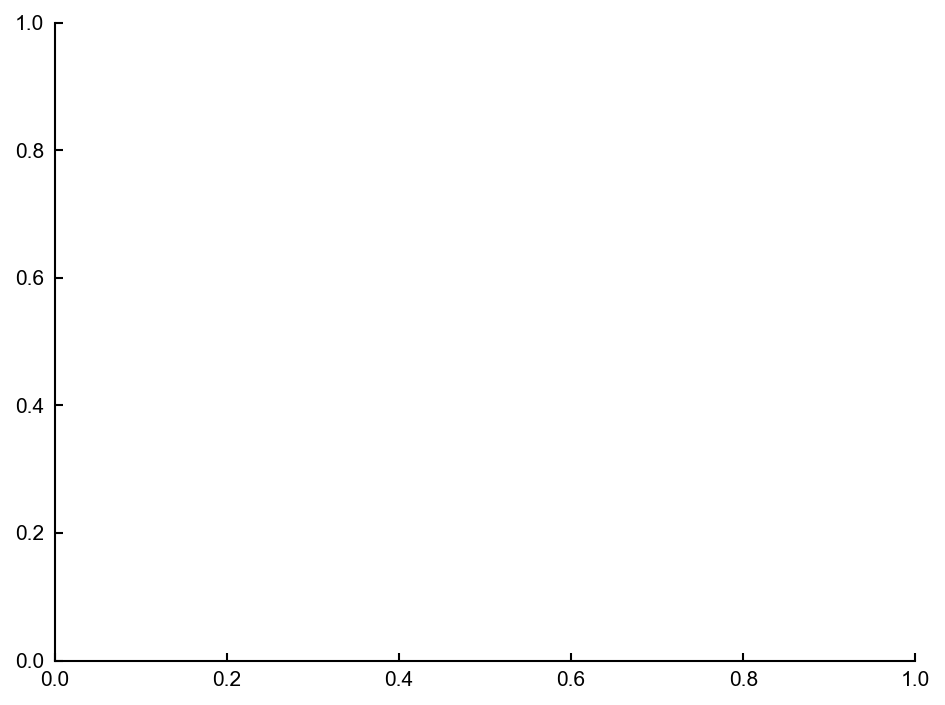

In [113]:
# f = plt.figure(figsize=(8, 4))
# gs = mpl.gridspec.GridSpec(2, 2)


# ax = plt.subplot(gs[0])
# ylim = (-10, 10)
# panelOptoVisResp(ax, ylim)

# ax = plt.subplot(gs[1])
# panelConfoundResp(ax, ylim)

# ax = plt.subplot(gs[2])
panelPowerWithFlicker(ax)

# ax = plt.subplot(gs[3])
# panelAllPowersFlicker(ax)


f.tight_layout()

# poster figs 

#### import

In [55]:
dataOp3 = wfOpto(Path(r'Y:\Subjects\ZYE_0069\2023-07-19\1'))

In [56]:
print(np.unique(dataOp3.laserPowers))
print(np.unique(dataOp3.galvoX))
print(np.unique(dataOp3.galvoY))

[0.5 1.  1.5 2.  3.2]
[0.  3.3]
[0.  3.3]


In [3]:
dataOp312 = wfOpto(Path(r'Y:\Subjects\AB_0026\2024-03-12\1'))

In [161]:
print(np.unique(dataOp312.laserPowers))
print(np.unique(dataOp312.galvoX))
print(np.unique(dataOp312.galvoY))

[0.2 0.5 1.  1.5 2.  2.5 3.2]
[-0.]
[-0.   1.5  2.5]


In [68]:
dataOp425 = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-04-25\1'))

In [159]:
print(np.unique(dataOp425.laserPowers))
print(np.unique(dataOp425.galvoX))
print(np.unique(dataOp425.galvoY))

[0.1 0.2 0.5 0.7 1.  1.5 1.7 2.  2.5 3.  3.2]
[-0.   3.3]
[-0.   3.3]


In [67]:
dataOp816 = wfOpto(Path(r'Y:\Subjects\ZYE_0069\2023-08-16\1'))

KeyboardInterrupt: 

In [ ]:
print(np.unique(dataOp816.laserPowers))
print(np.unique(dataOp816.galvoX))
print(np.unique(dataOp816.galvoY))

In [4]:
dataVis611_No=wfOpto(Path(r'Y:\Subjects\AL_0032\2024-06-11\1'))

In [28]:
dataVis610_Yes=wfOpto(Path(r'Y:\Subjects\AL_0032\2024-06-10\1'))

In [53]:
print(np.unique(dataVis611_No.laserPowers))
print(np.unique(dataVis611_No.galvoX))
print(np.unique(dataVis611_No.galvoY))

[0.1 0.2 0.5 0.7 1.  1.5 1.7 2.  2.5 3.  3.2]
[1.1 1.6 2.  2.7 2.8 3. ]
[1.4 2.5 2.7 3.  3.1 5.  7. ]


In [43]:
print(np.unique(dataVis610_Yes.laserPowers))
print(np.unique(dataVis610_Yes.galvoX))
print(np.unique(dataVis610_Yes.galvoY))

[0.1 0.2 0.5 0.7 1.  1.5 1.7 2.  2.5 3.  3.2]
[-0.   0.6  2. ]
[-0.   0.8  2.5  3.5  4.5  5.5  6.5]


In [69]:
theseTrs = np.argwhere(dataOp425.laserPowers == 3.2).ravel()
locy=np.argwhere(dataOp425.galvoY==0).ravel()
locx=np.argwhere(dataOp425.galvoX==0).ravel()
loc=np.intersect1d(locx,locy)
onTimes = dataOp425.laserOn[np.intersect1d(theseTrs,loc)]
print(len(onTimes))

40


In [45]:
locy

array([], dtype=int64)

In [8]:
print(np.unique(dataOp816.laserPowers))
print(np.unique(dataOp816.galvoX))
print(np.unique(dataOp816.galvoY))

[0.1 0.2 0.5 0.7 1.  1.2 1.5 1.7 2. ]
[-0.01 -0.  ]
[-0.01 -0.  ]


In [2]:
dataVis610=wfOpto(Path(r'Y:\Subjects\AL_0032\2024-06-10\1'))

In [27]:
dataVis427=wfOpto(Path(r'Y:\Subjects\AL_0032\2024-04-27\1'))

ValueError: x and y arrays must be equal in length along interpolation axis.

#### simple time plot and effect at peak

In [20]:
from scipy.ndimage import gaussian_filter1d

In [9]:
a=5/1.8
3.2/a

1.1520000000000001

In [104]:
def powerInac():
    '''
   inactivation across x number of powers
    '''
    f = plt.figure(figsize=(4/1.5, 3/1.5), dpi=300)
    ax = plt.gca()
    colors=['deepskyblue','dodgerblue','mediumblue']
    powers = np.array([0.4,1.1,3.2])
    pixel = (198, 246)
    pxPowers = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    specs='ZYE 7/17'
    pixel_ix = np.ravel_multi_index((246, 198), (data717.py, data717.px))
    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data717.laserPowers[data717.listExps[0]] == power).ravel()
        locTrs=np.argwhere(data717.galvoX[data717.listExps[0]]==3.3).ravel()
        onTimes = data717.laserOn[data717.listExps[0]][np.intersect1d(pwTrs,locTrs)]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        print(len(pwTrs))
        print(len(locTrs))
        print(len(onTimes))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = data717.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data717.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)
        for c,iP in enumerate(pxPowers):
            plt.plot(timestamps, np.mean(iP, axis=0),linewidth=2,color=colors[c])
        plt.fill_between(timestamps, \
                    np.mean(iP, axis=0)-scipy.stats.sem(iP,axis=0),\
                    np.mean(iP,axis=0)+scipy.stats.sem(iP,axis=0), color=colors[c], label='_nolegend_',alpha=.3,linewidth=0)
        # plt.legend(f'{powers}', loc='upper right',bbox_to_anchor=(1.2,1))
        plt.xlabel('Time (ms)')
        plt.ylabel('Brain Activity ($\Delta F$/F)')
        plt.title(f'Brain Activity {specs}')
        plt.xlim([-100,500])
        plt.axvspan(0,100,color='gray',alpha=.2,lw=0,label='_nolegend_')
    

<>:42: SyntaxWarning: invalid escape sequence '\D'
<>:42: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_10076\2025326732.py:42: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('Brain Activity ($\Delta F$/F)')


In [95]:
colors=['deepskyblue','dodgerblue','mediumblue']
powers = np.array([0.5,1,2])
pixel = (198, 246)
pxPowers = []
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

specs='AB32 3/12'
pixel_ix = np.ravel_multi_index((246, 198), (dataOp816.py, dataOp816.px))
for iP, power in enumerate(powers):
    pwTrs = np.argwhere(dataOp816.laserPowers == power).ravel()
    onTimes = dataOp816.laserOn[pwTrs]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    print(len(trs))

50
50
50


In [107]:
def powerDep():
    '''
    how power impacts inactivation
    '''
    f = plt.figure(figsize=(4/1.5, 3/1.5), dpi=300)
    powers = np.unique(data717.laserPowers[data717.listExps[0]])
    pixel = (198, 246)
    pxPowers = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    specs='AB32 4/25'
    pixel_ix = np.ravel_multi_index((246, 198), (data717.py, data717.px))
    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data717.laserPowers[data717.listExps[0]] == power).ravel()
        locTrs=np.argwhere(data717.galvoX[data717.listExps[0]]==3.3).ravel()
        onTimes = data717.laserOn[data717.listExps[0]][np.intersect1d(pwTrs,locTrs)]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = data717.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data717.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

    pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=2, fill_value='extrapolate')

    time90 = pixelInterp(90)

    timeMean = np.mean(time90, axis=1)
    plt.plot(powers,timeMean,'-o',c='k',lw=2)
    plt.errorbar(powers,timeMean,yerr=.8,c='k')
    plt.scatter(powers,timeMean)
    plt.xlabel("Laser powers (mW)")
    plt.ylabel("Brain Activity ($\Delta F$/F)")
    # plt.xticks([0.2, 1.7, 3], [0.07, 0.63, 1.1])
    plt.title(f"Brain inactivation at peak (90 ms) {specs}")

<>:40: SyntaxWarning: invalid escape sequence '\D'
<>:40: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_10076\981451945.py:40: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("Brain Activity ($\Delta F$/F)")


In [176]:
data=dataOp312

In [61]:
def powerDepAllPow(data,ylim):
    f = plt.figure(figsize=(4/1.5, 3/1.5), dpi=300)
    powers = np.unique(data.laserPowers)
    pixel = (198, 246)
    pxPowers = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    specs='AB32 3/12'
    pixel_ix = np.ravel_multi_index((246, 198), (data.py, data.px))
    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(dataOp425.laserPowers == power).ravel()
        locTrs=np.argwhere(dataOp425.galvoY==3.3).ravel() #depends on recording
        onTimes = dataOp425.laserOn[np.intersect1d(pwTrs,locTrs)]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

        for iP in pxPowers:
            plt.plot(timestamps, np.mean(iP, axis=0),color='k',lw=1)
        plt.xlabel('time (ms)')
        plt.title(f'Inactivation All Powers {specs}')
        plt.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
        plt.ylim(ylim)

59
178
28
60
178
31
54
178
30


(-10.0, 10.0)

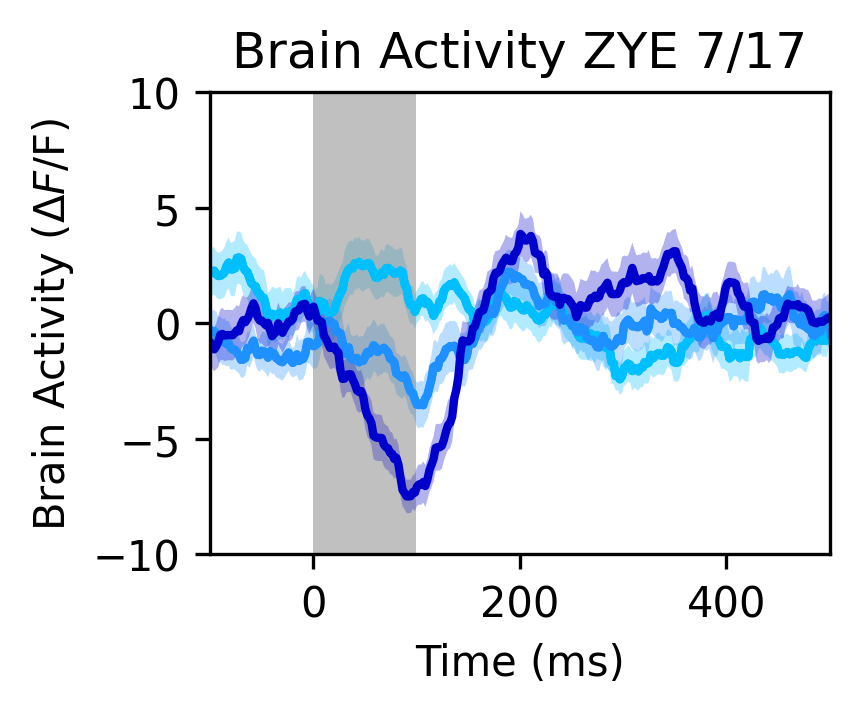

In [106]:
powerInac()
plt.ylim([-10,10])

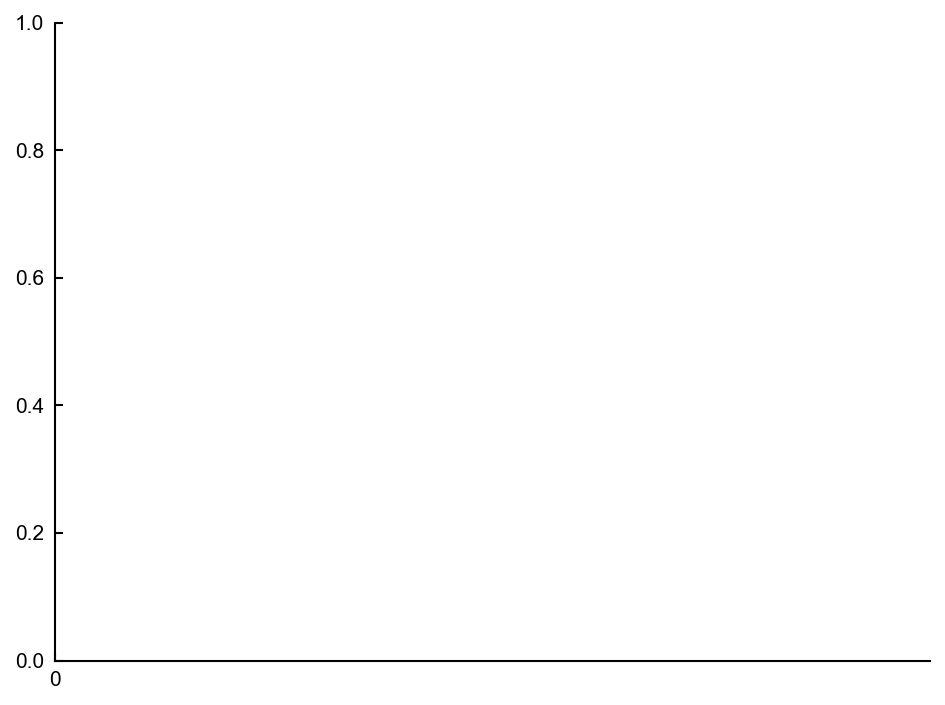

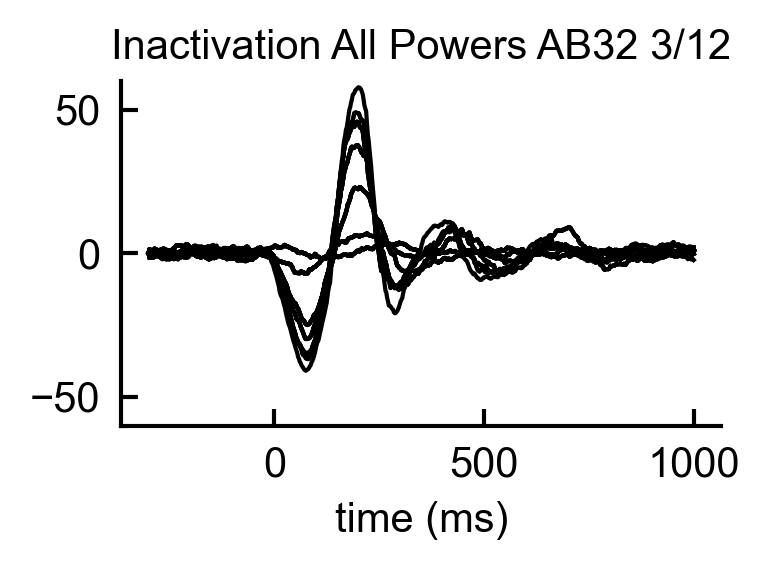

In [190]:
powerDepAllPow(data=dataOp312,ylim=[-10,10])

In [108]:
powerDep()

C:\Users\nadia\AppData\Local\Temp\ipykernel_10076\981451945.py:40: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("Brain Activity ($\Delta F$/F)")


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

<Figure size 800x600 with 0 Axes>

#### Consistency

In [106]:
from scipy.ndimage import gaussian_filter1d

<>:40: SyntaxWarning: invalid escape sequence '\D'
<>:40: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_5512\1806636075.py:40: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('Brain Activity ($\Delta F$/F)')


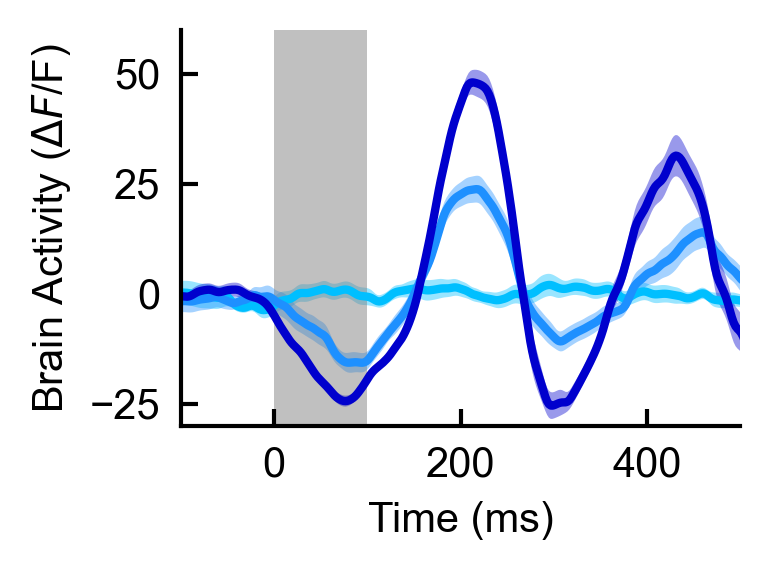

In [83]:
f = plt.figure(figsize=(4/1.5, 3/1.5), dpi=300)
ax = plt.gca()
powers =np.array([0.2,1,3.2])
colors=['deepskyblue','dodgerblue','mediumblue']
pixel = (150, 428)
pxPowers = []
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((428, 150), (dataOp312.py, dataOp312.px))
for iP, power in enumerate(powers):
    pow = np.argwhere(dataOp312.laserPowers == power).ravel()
    loc=np.argwhere(dataOp312.galvoX==0).ravel()
    powloc=np.intersect1d(pow,loc)
    locY=np.argwhere(dataOp312.galvoY==2.5).ravel()
    theseTrs=np.intersect1d(powloc,locY)

    onTimes = dataOp312.laserOn[theseTrs]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    thisPower = []
    for iT, tr in enumerate(trs):
        wf = dataOp312.tToWFManual(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = dataOp312.svdSpat[pixel_ix] @ dwf
        thisPower.append(mov)
    thisPower = np.array(thisPower)
    pxPowers.append(thisPower)

    for c,iP in enumerate(pxPowers):
        iP = gaussian_filter1d(iP, sigma=2)
    plt.plot(timestamps, np.mean(iP, axis=0),color=colors[c],lw=2)   
    plt.fill_between(timestamps, \
                 np.mean(iP, axis=0)-scipy.stats.sem(iP,axis=0),\
                 np.mean(iP,axis=0)+scipy.stats.sem(iP,axis=0), color=colors[c], label='_nolegend_',alpha=.4,linewidth=0)
    # plt.legend(['0.07', '0.63', '1.1'], loc='upper right',bbox_to_anchor=(1.2,1))
    plt.xlabel('Time (ms)')
    plt.ylabel('Brain Activity ($\Delta F$/F)')
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    plt.ylim([-30,60])
    plt.xlim([-100,500])
    plt.axvspan(0,100,color='gray',alpha=.2,lw=0,label='_nolegend_')

<>:39: SyntaxWarning: invalid escape sequence '\D'
<>:39: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_5512\1072516728.py:39: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('Brain Activity ($\Delta F$/F)')


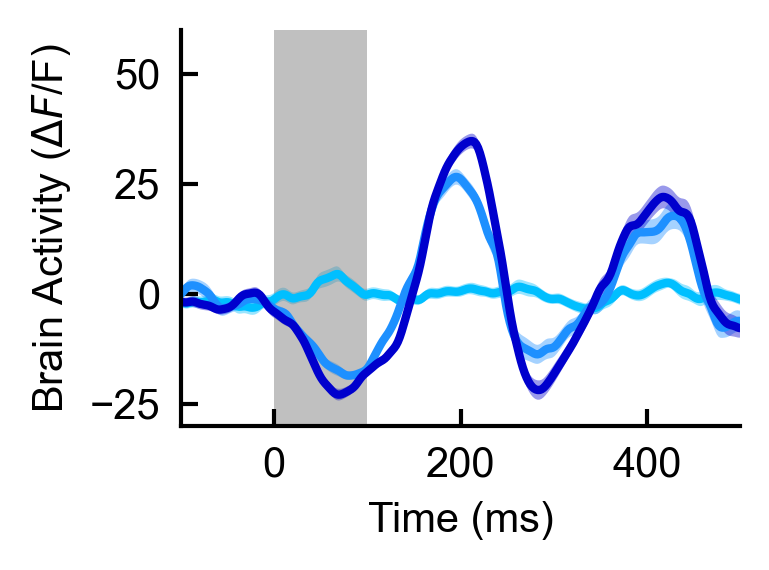

In [87]:
f = plt.figure(figsize=(4/1.5, 3/1.5), dpi=300)
ax = plt.gca()
powers = np.array([0.2,1,3.2])
colors=['deepskyblue','dodgerblue','mediumblue']
pixel = (150, 428)
pxPowers = []
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((428, 150), (dataOp425.py, dataOp425.px))
for iP, power in enumerate(powers):
    pow = np.argwhere(dataOp425.laserPowers == power).ravel()
    loc=np.argwhere(dataOp425.galvoX==0).ravel()
    powloc=np.intersect1d(pow,loc)
    locY=np.argwhere(dataOp425.galvoY==3.3).ravel()
    theseTrs=np.intersect1d(powloc,locY)
    
    onTimes = dataOp425.laserOn[theseTrs]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    thisPower = []
    for iT, tr in enumerate(trs):
        wf = dataOp425.tToWFManual(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = dataOp425.svdSpat[pixel_ix] @ dwf
        thisPower.append(mov)
    thisPower = np.array(thisPower)
    pxPowers.append(thisPower)

    for c,iP in enumerate(pxPowers):
        iP = gaussian_filter1d(iP, sigma=2)
    plt.plot(timestamps, np.mean(iP, axis=0),color=colors[c],lw=2)
    plt.fill_between(timestamps, \
                 np.mean(iP, axis=0)-scipy.stats.sem(iP,axis=0),\
                 np.mean(iP,axis=0)+scipy.stats.sem(iP,axis=0), color=colors[c], label='_nolegend_',alpha=.4,lw=0)
    plt.xlabel('Time (ms)')
    plt.ylabel('Brain Activity ($\Delta F$/F)')
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    plt.ylim([-30,60])
    plt.xlim([-100,500])
    plt.axvspan(0,100,color='gray',alpha=.2,lw=0,label='_nolegend_')

In [84]:
def stimLeft(ax):
    power = .7
    n_samples=650
    timestamps=np.linspace(-.3,1,n_samples)*1000

    pixel_Right=np.ravel_multi_index((200,410),(dataOp425.py, dataOp425.px))
    pixel_Left = np.ravel_multi_index((200,160),(dataOp425.py,dataOp425.px))
    theseTrs = np.argwhere(dataOp425.laserPowers==power).ravel()
    onTimes=dataOp425.laserOn[theseTrs]
    trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))

    thisPowerLeft=[]
    thisPowerRight=[]
    for iT, tr in enumerate(trs):
        wf=dataOp425.tToWf(tr)
        dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
        dwf=np.array(dwf)
        
        movRight=dataOp425.svdSpat[pixel_Right]@dwf
        thisPowerRight.append(movRight)
        movLeft=dataOp425.svdSpat[pixel_Left]@dwf
        thisPowerLeft.append(movLeft)

    thisPowerLeft=np.array(thisPowerLeft)
    thisPowerRight=np.array(thisPowerRight)
    plt.plot(timestamps,np.mean(thisPowerLeft,axis=0),color='green',label='Left')
    plt.plot(timestamps,np.mean(thisPowerRight,axis=0),color='orange',label='Right')
    plt.legend()
    plt.title(f'Stimulating Upper Right {power}')
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0,label='_nolegend_')
    plt.ylim([-30,30])

def stimRight(ax):
    power = .7
    n_samples=650
    timestamps=np.linspace(-.3,1,n_samples)*1000
    power = np.argwhere(dataOp425.laserPowers==power).ravel()
    galvoX=np.argwhere(dataOp425.galvoX==3.3).ravel()
    galvoY=np.argwhere(dataOp425.galvoY==0).ravel()

    px = np.intersect1d(power,galvoX)
    theseTrs=np.intersect1d(px,galvoY)

    pixel_Right=np.ravel_multi_index((200,410),(dataOp425.py, dataOp425.px))
    pixel_Left = np.ravel_multi_index((200,160),(dataOp425.py,dataOp425.px))
    onTimes=dataOp425.laserOn[theseTrs]
    trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))

    thisPowerLeft=[]
    thisPowerRight=[]
    for iT, tr in enumerate(trs):
        wf=dataOp425.tToWf(tr)
        dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
        dwf=np.array(dwf)
        
        movRight=dataOp425.svdSpat[pixel_Right]@dwf
        thisPowerRight.append(movRight)
        movLeft=dataOp425.svdSpat[pixel_Left]@dwf
        thisPowerLeft.append(movLeft)

    thisPowerLeft=np.array(thisPowerLeft)
    thisPowerRight=np.array(thisPowerRight)
    plt.plot(timestamps,np.mean(thisPowerLeft,axis=0),color='green',label='Left')
    plt.plot(timestamps,np.mean(thisPowerRight,axis=0),color='orange',label='Right')
    plt.legend()
    plt.title(f'Stimulating Upper Right {power}')
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0,label='_nolegend_')
    plt.ylim([-30,30])

<>:32: SyntaxWarning: invalid escape sequence '\D'
<>:72: SyntaxWarning: invalid escape sequence '\D'
<>:32: SyntaxWarning: invalid escape sequence '\D'
<>:72: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_16324\1501196892.py:32: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta F$')
C:\Users\nadia\AppData\Local\Temp\ipykernel_16324\1501196892.py:72: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta F$')


In [ ]:
[0.1 0.2 0.5 0.7 1.  1.5 1.7 2.  2.5 3.  3.2]

In [150]:
def stimLowerLeft(ax):
    f = plt.figure(figsize=(4/1.5, 3/1.5), dpi=300)
    ax = plt.gca()
    power_pick = 1
    n_samples=650
    timestamps=np.linspace(-.3,1,n_samples)*1000
    power = np.argwhere(dataOp425.laserPowers==power_pick).ravel()
    galvoX=np.argwhere(dataOp425.galvoX==0).ravel()
    galvoY=np.argwhere(dataOp425.galvoY==3.3).ravel()

    px = np.intersect1d(power,galvoX)
    theseTrs=np.intersect1d(px,galvoY)

    pixel_Right=np.ravel_multi_index((430,500),(dataOp425.py, dataOp425.px))
    pixel_Left = np.ravel_multi_index((430,160),(dataOp425.py,dataOp425.px))
    onTimes=dataOp425.laserOn[theseTrs]
    trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))

    thisPowerLeft=[]
    thisPowerRight=[]
    for iT, tr in enumerate(trs):
        wf=dataOp425.tToWf(tr)
        dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
        dwf=np.array(dwf)
        
        movRight=dataOp425.svdSpat[pixel_Right]@dwf
        thisPowerRight.append(movRight)
        movLeft=dataOp425.svdSpat[pixel_Left]@dwf
        thisPowerLeft.append(movLeft)

    thisPowerLeft=np.array(thisPowerLeft)
    thisPowerRight=np.array(thisPowerRight)
    plt.plot(timestamps,np.mean(thisPowerLeft,axis=0),color='green',label='Left')
    plt.plot(timestamps,np.mean(thisPowerRight,axis=0),color='orange',label='Right')
    plt.legend()
    plt.title(f'Stimulating Lower Left {power_pick}')
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0,label='_nolegend_')
    plt.ylim([-30,30])

def stimLowerRight(ax):
    power_pick = 1.7
    n_samples=650
    timestamps=np.linspace(-.3,1,n_samples)*1000
    power = np.argwhere(dataOp425.laserPowers==power_pick).ravel()
    galvoX=np.argwhere(dataOp425.galvoX==3.3).ravel()
    galvoY=np.argwhere(dataOp425.galvoY==3.3).ravel()

    px = np.intersect1d(power,galvoX)
    theseTrs=np.intersect1d(px,galvoY)

    pixel_Right=np.ravel_multi_index((430,450),(dataOp425.py, dataOp425.px))
    pixel_Left = np.ravel_multi_index((430,160),(dataOp425.py,dataOp425.px))
    onTimes=dataOp425.laserOn[theseTrs]
    trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))

    thisPowerLeft=[]
    thisPowerRight=[]
    for iT, tr in enumerate(trs):
        wf=dataOp425.tToWf(tr)
        dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
        dwf=np.array(dwf)
        
        movRight=dataOp425.svdSpat[pixel_Right]@dwf
        thisPowerRight.append(movRight)
        movLeft=dataOp425.svdSpat[pixel_Left]@dwf
        thisPowerLeft.append(movLeft)

    thisPowerLeft=np.array(thisPowerLeft)
    thisPowerRight=np.array(thisPowerRight)
    plt.plot(timestamps,np.mean(thisPowerLeft,axis=0),color='green',label='Left')
    plt.plot(timestamps,np.mean(thisPowerRight,axis=0),color='orange',label='Right')
    plt.legend()
    plt.title(f'Stimulating Lower Right {power_pick}')
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0,label='_nolegend_')
    plt.ylim([-30,30])

<>:37: SyntaxWarning: invalid escape sequence '\D'
<>:77: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\D'
<>:77: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_16324\3190438750.py:37: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta F$')
C:\Users\nadia\AppData\Local\Temp\ipykernel_16324\3190438750.py:77: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta F$')


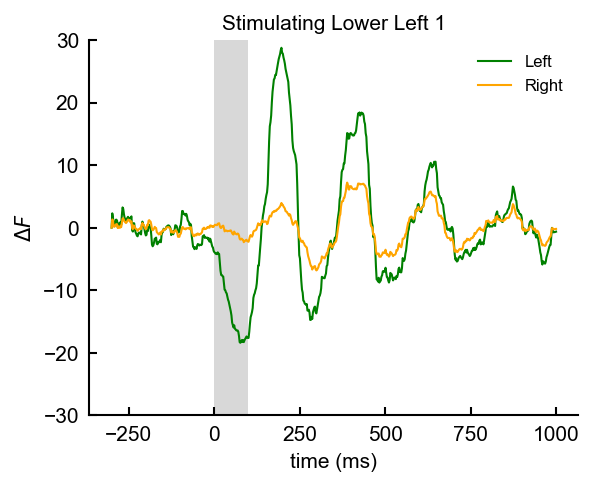

In [151]:
f = plt.figure(figsize=(7.5,6))
gs=mpl.gridspec.GridSpec(2,2)

# ax = plt.subplot(gs[0])
# stimLeft(ax)

# ax = plt.subplot(gs[1])
# stimRight(ax)

ax = plt.subplot(gs[2])
stimLowerLeft(ax)

# ax = plt.subplot(gs[3])
# stimLowerRight(ax)

f.tight_layout()

#### trial vids

In [124]:
import random
# 4/25 [0.1 0.2 0.5 0.7 1.  1.5 1.7 2.  2.5 3.  3.2]

#3/12 [0.2 0.5 1.  1.5 2.  2.5 3.2]

#8/16 

#7/19


In [58]:
pows = np.argwhere(data830.laserPowers==3).ravel()
# galvoY=np.argwhere(data830.galvoY==2.5)
# galvoX=np.argwhere(data830.galvoX==0)
# loc=np.intersect1d(galvoX,galvoY)
# theseTrs=np.intersect1d(loc,pows)
theseTrs=pows

allVideos=[]
for trial in theseTrs:
    startTime = data830.laserOn[data830.listExps[0][trial]]
    endTime = data830.laserOn[data830.listExps[0][trial]] + .5
    
    trial_time = np.linspace(startTime, endTime, 100)
    trial_activity = data830.tToWf(trial_time)
    dwf = [np.diff(i, prepend=i[0]) for i in trial_activity.T]
    dwf = np.array(dwf)
    
    # avg_trial_activity = np.mean(dwf, axis=1)

    videoAvg = data830.spatial @ dwf
    videoAvg = videoAvg.reshape(560,560,-1)

    allVideos.append(videoAvg)

allVideos = np.array(allVideos)


KeyboardInterrupt: 

In [41]:
allVideos.shape

(560, 100)

In [ ]:
allVideos=np.mean(allVideos,axis=0)

In [ ]:
#DONT EDIT THIS
clim=np.percentile(videoAvg,(0,100))
true_colorbar=clim

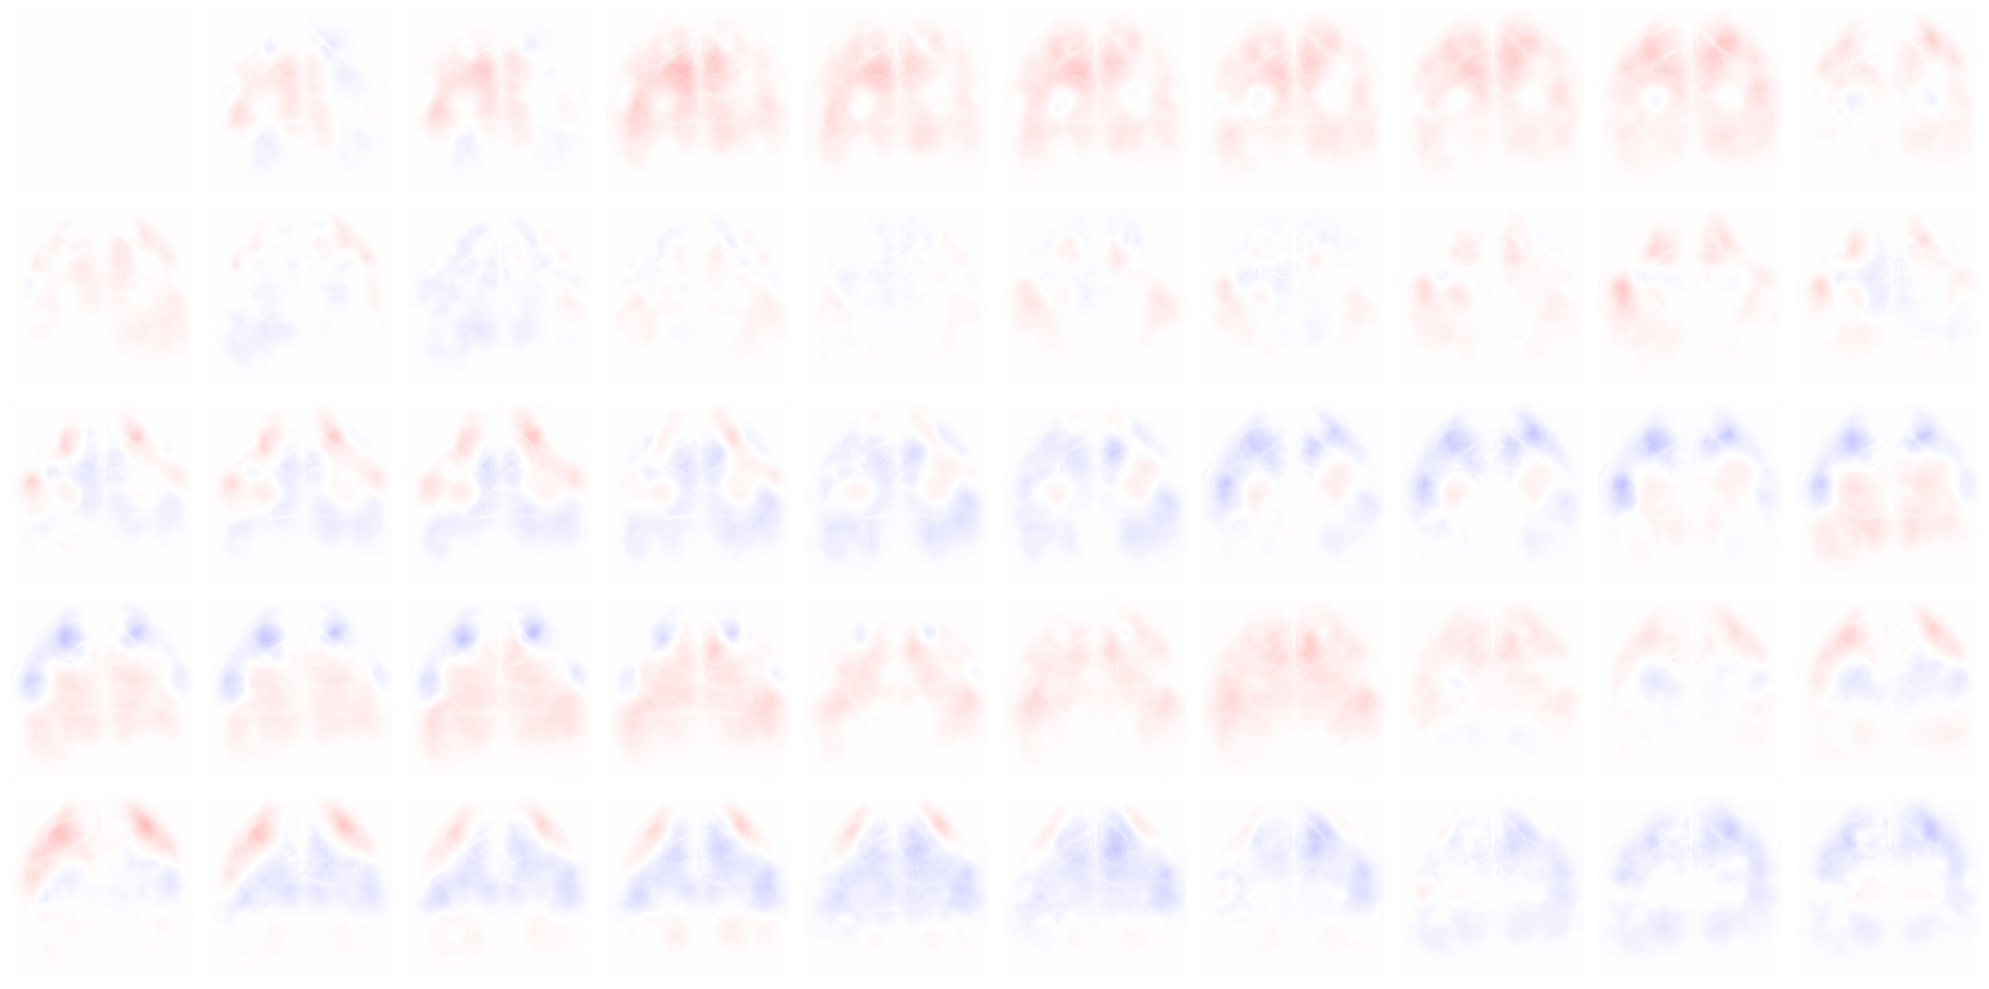

In [ ]:
n_cols = 10
n_rows = 5
f = plt.figure(figsize=(n_cols*2, n_rows*2))
gs = mpl.gridspec.GridSpec(n_rows, n_cols)
for i in range(50):
    ax = plt.subplot(gs[i])
    plt.imshow(allVideos[:, :,i*2],clim = true_colorbar, cmap='bwr',vmax=100,vmin=-100)
    #plt.colorbar()
    plt.axis('off')

f.tight_layout()

#### some importing

In [6]:
serverPath = Path(r'Y:\Subjects\AL_0032\2024-04-27\1')
timeFile = serverPath / 'cameraFrameTimes.npy'
frameTimes = np.squeeze(np.load(timeFile))[::2] # every other frame - we want blue only
svdTemp = np.load(serverPath / 'corr/svdTemporalComponents_corr.npy')
svdSpat = np.load(serverPath / 'blue/svdSpatialComponents.npy')
svdSpatFull = svdSpat[:,:,:500]

meanImage = np.load(serverPath / 'blue/meanImage.npy')
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
laserPowers = np.squeeze(np.load(serverPath /'laserPowers.npy'))
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
px, py, ncomps = svdSpatFull.shape

svdSpat = svdSpatFull.reshape(px*py, ncomps)

In [16]:
tToWf = scipy.interpolate.interp1d(frameTimes[47435:], svdTemp, axis=0, fill_value='extrapolate')
spatial = svdSpatFull.reshape(560*560,-1)

([], [])

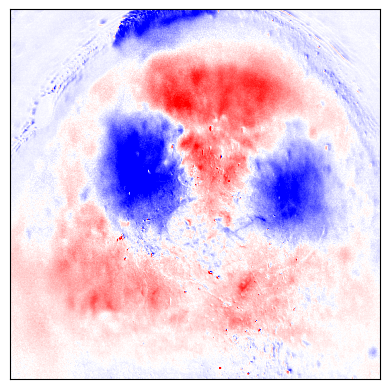

In [38]:
pows = np.argwhere(laserPowers==3).ravel()
galvoY=np.argwhere(galvoY==0)
theseTrs=np.intersect1d(pows,galvoY)
trial_time_all = [np.linspace(i+-.3, i+1, 100) for i in theseTrs]
trial_activity_all = tToWf(trial_time_all)
trial_activity_all = np.mean(trial_activity_all, axis=0)

dwf = [np.diff(i, prepend=i[0]) for i in trial_activity_all]
dwf = np.array(dwf)


spatial = svdSpatFull.reshape(560*560, -1)
videoAvg = spatial @ dwf.T
videoAvg = videoAvg.reshape(560,560,-1)
videoAvg = np.mean(videoAvg, axis=2)
plt.imshow(videoAvg, cmap='bwr',clim = np.percentile(videoAvg, (2, 99.9)))
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

#### workshopping visresp

In [13]:
#DO NOT DELTE!!!! 
#flicker
dataVisFlicker=wfOpto(Path(r'Y:\Subjects\AL_0032\2024-04-28\1'))

In [16]:
np.unique(dataVisFlicker.laserPowers)

array([0.1, 0.2, 0.5, 0.7, 1. , 1.5, 1.7, 2. , 2.5, 3. , 3.2])

In [ ]:
pows = np.argwhere(dataVisFlicker.laserPowers==3).ravel()
galvoX=np.argwhere(dataVisFlicker.galvoY==0)
theseTrs=np.intersect1d(pows,galvoX)
trial_time_all = [np.linspace(i+-.3, i+1, 100) for i in theseTrs]
trial_activity_all = dataVisFlicker.tToWf(trial_time_all)
trial_activity_all = np.mean(trial_activity_all, axis=0)

dwf = [np.diff(i, prepend=i[0]) for i in trial_activity_all]
dwf = np.array(dwf)

spatial = dataVisFlicker.svdSpatFull.reshape(560*560, -1)
videoAvg = spatial @ dwf.T
videoAvg = videoAvg.reshape(560,560,-1)
videoAvg = np.mean(videoAvg, axis=2)
plt.imshow(videoAvg, cmap='bwr',clim = np.percentile(videoAvg, (2, 99.9)))
# plt.xlabel('')
# plt.ylabel('')
# plt.xticks([])
# plt.yticks([])

Text(0.5, 1.0, '3 mW opto stim')

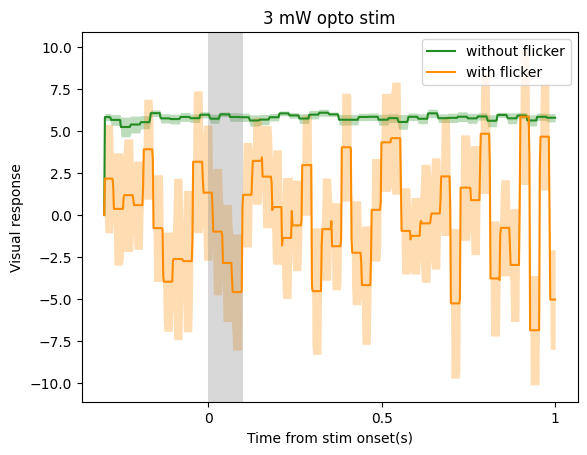

In [39]:
pixel = (150, 428)
n_samples = 1000
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((428, 150), (dataVisFlicker.py, dataVisFlicker.px))
power=2.5
pows = np.argwhere(dataVisFlicker.laserPowers[dataVisFlicker.listExps[0]] == power).ravel()
location=0
loc=np.argwhere(dataVisFlicker.galvoY==location)
onTimes=np.intersect1d(pows,loc)
trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

flicker = []
for iT, tr in enumerate(trs):
    wf = dataVisFlicker.tToWFManual(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = dataVisFlicker.svdSpat[pixel_ix] @ dwf
    flicker.append(mov)
flicker = np.array(flicker)

plt.plot(timestamps, np.mean(flicker, axis=0), color='red')
plt.fill_between(timestamps, \
                    np.mean(flicker, axis=0)-scipy.stats.sem(flicker,axis=0),\
                    np.mean(flicker,axis=0)+scipy.stats.sem(flicker,axis=0), color='red', alpha=0.3, lw=0, label='_nolegend_')

plt.legend()
plt.ylim(None, 8)
plt.xticks([0, 500, 1000], [0, 0.5, 1],size=15)
plt.yticks(size=15)
plt.xlabel('Time from stim onset(s)',size=15)
plt.ylabel('Visual Response ($\Delta F$/F)',size=15)
plt.title(f'{power} mW opto stim at Y={location}',size=20)
plt.axvspan(0,100,color='gray',alpha=.3,lw=0,label='_nolegend_')


#### location and visresp

In [142]:
dataVis=wfOpto((Path(r'Y:\Subjects\AL_0023\2023-08-24\1')))

In [42]:
dataVis=dataVis610_Yes

(-0.5, 559.5, 559.5, -0.5)

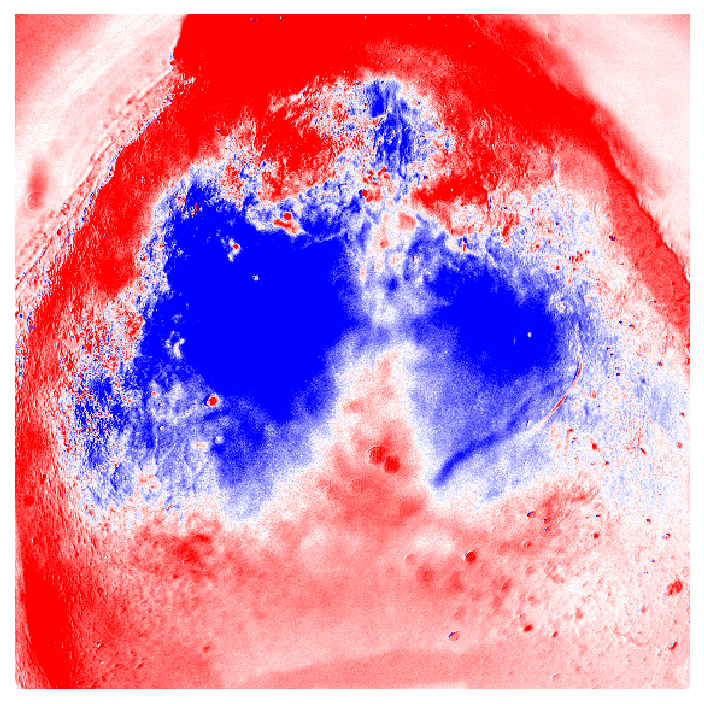

In [18]:
pows = np.argwhere(dataVis.laserPowers==2.5).ravel()
galvoX=np.argwhere(dataVis.galvoY==2.5)
theseTrs=np.intersect1d(pows,galvoX)
trial_time_all = [np.linspace(i+.05, i+.1,100) for i in theseTrs]
trial_activity_all = dataVis.tToWf(trial_time_all)
trial_activity_all = np.mean(trial_activity_all, axis=0)

dwf = [np.diff(i, prepend=i[0]) for i in trial_activity_all]
dwf = np.array(dwf)
spatial = dataVis.svdSpatFull.reshape(560*560, -1)
videoAvg = spatial @ dwf.T
videoAvg = videoAvg.reshape(560,560,-1)
videoAvg = np.mean(videoAvg, axis=2)
clim_real=np.percentile(videoAvg, (2, 99.9))
plt.imshow(videoAvg, cmap='bwr',clim = clim_real,vmax=100,vmin=-100)
# plt.xlabel('')
# plt.ylabel('')
# plt.xticks([])
# plt.yticks([])
plt.axis("off")

In [19]:
theseTrs

array([  50,   61,   85,  149,  198,  215,  243,  248,  280,  290,  305,
        348,  468,  478,  489,  539,  709,  732,  781,  814,  836,  845,
        883,  917,  922,  927,  939,  948,  986, 1014], dtype=int64)

In [52]:
pows = np.argwhere(dataVis.laserPowers==3).ravel()
galvoY=np.argwhere(dataVis.galvoY==2.5)
theseTrs=np.intersect1d(loc,galvoY)

allVideos=[]
for trial in theseTrs:
    startTime = dataVis.laserOn[dataVis.listExps[0][trial]]
    endTime = dataVis.laserOn[dataVis.listExps[0][trial]] + .5
    
    trial_time = np.linspace(startTime, endTime, 100)
    trial_activity = dataVis.tToWf(trial_time)
    dwf = [np.diff(i, prepend=i[0]) for i in trial_activity.T]
    dwf = np.array(dwf)
    
    # avg_trial_activity = np.mean(dwf, axis=1)

    videoAvg = dataVis.spatial @ dwf
    videoAvg = videoAvg.reshape(560,560,-1)

    allVideos.append(videoAvg)

allVideos = np.array(allVideos)
allVideos=np.mean(allVideos,axis=0)
clim=np.percentile(allVideos,(0,100))


MemoryError: Unable to allocate 25.2 GiB for an array with shape (108, 560, 560, 100) and data type float64

In [37]:
theseTrs

array([], dtype=int64)

In [25]:
allVideos.shape

(560, 560, 100)

In [40]:
#DONT EDIT THIS
true_colorbar=np.percentile(allVideos,(2,99.9))

IndexError: invalid index to scalar variable.

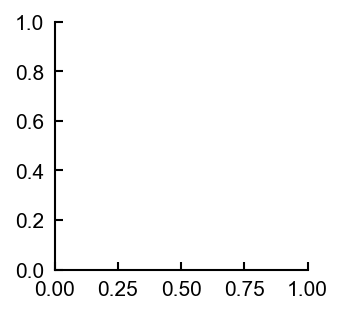

In [ ]:
n_cols = 10
n_rows = 5
f = plt.figure(figsize=(n_cols*2, n_rows*2))
gs = mpl.gridspec.GridSpec(n_rows, n_cols)
for i in range(50):
    ax = plt.subplot(gs[i])
    plt.imshow(allVideos[:, :,i*2],clim = np.percentile(allVideos,(2,99.9)), cmap='bwr',vmax=100,vmin=-100)
    #plt.colorbar()
    # plt.axis('off')

f.tight_layout()

In [ ]:
#DONT EDIT THIS
true_colorbar=clim

In [ ]:
print(np.unique(dataVis.laserPowers))
print(np.unique(dataVis.galvoX))
print(np.unique(dataVis.galvoY))

[0.1 0.2 0.5 0.7 1.  1.5 1.7 2.  2.5 3.  3.2]
[-0.]
[-0.   1.5  2.5]


<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_19332\2411214445.py:34: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('visual cortex activity ($\Delta F$/F)')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


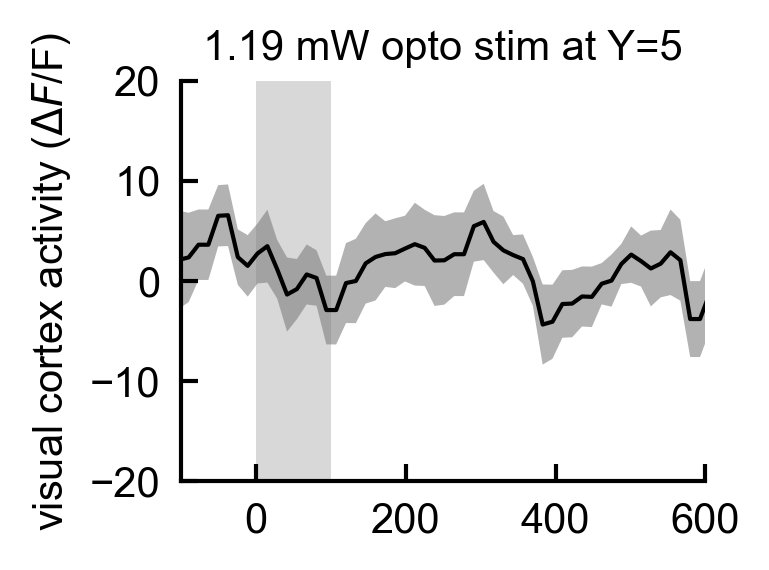

In [32]:
f = plt.figure(figsize=(4/1.5, 3/1.5), dpi=300)
ax = plt.gca()
pixel = (150, 428)
n_samples = 100
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((428, 150), (dataVis.py, dataVis.px))
power=3.2
pows = np.argwhere(dataVis.laserPowers[dataVis.listExps[0]] == power).ravel()
location=5
loc=np.argwhere(dataVis.galvoY==location)
onTimes=np.intersect1d(pows,loc)
trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

flicker = []
for iT, tr in enumerate(trs):
    wf = dataVis.tToWFManual(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = dataVis.svdSpat[pixel_ix] @ dwf
    flicker.append(mov)
flicker = np.array(flicker)

plt.plot(timestamps, np.mean(flicker, axis=0), color='black')
plt.fill_between(timestamps, \
                    np.mean(flicker, axis=0)-scipy.stats.sem(flicker,axis=0),\
                    np.mean(flicker,axis=0)+scipy.stats.sem(flicker,axis=0), color='black', alpha=0.3, lw=0, label='_nolegend_')

plt.legend()
plt.ylim([-20,20])
plt.xlim([-100,600])
# plt.xlabel('Time from stim onset(s)')
plt.ylabel('visual cortex activity ($\Delta F$/F)')
plt.title(f'{power/2.7:.2f} mW opto stim at Y={location}')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
plt.axvspan(0,100,color='gray',alpha=.3,lw=0,label='_nolegend_')


In [145]:
flicker.shape

(50, 1000)

#### spatial

# graveyard

In [ ]:

flicker = np.array(flicker)
plt.plot(timestamps, np.mean(flicker, axis=0))
plt.title(f'power {power}')
plt.xlabel('time (ms)')
plt.ylabel('$\Delta F$')

In [ ]:
ig, axs = plt.subplots(1,3,figsize=(10,3))
flicker_scale = flicker*.45454545
axs[0].plot(timestamps,opto)
axs[0].set_title("Optogenetic Stimulation")
axs[0].set_xlabel('time (ms)')
axs[0].set_ylabel('brain activity')
axs[1].plot(timestamps,flicker_scale)
axs[1].set_title("Visual Response")
axs[1].set_xlabel('time (ms)')
axs[1].set_ylabel('brain activity')
axs[2].plot(timestamps,flicker_scale+opto)
axs[2].set_title("Resultant brain activity of\nOpto. and Visual Responses")
axs[2].set_xlabel('time (ms)')
axs[2].set_ylabel('brain activity')

plt.show()